<img src="assets/title.png" width="800px"/>

<br><br>

# Experiments

In this notebook, we explore data and experiment iteratively.

## Part 1 - Data Exploration

2 datasets are used:
- TLC NYC Taxi trips (2015) - [link](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- NOAA Climate data of JFK airport, NYC (2015) - [link](https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail)

### TLC NYC Taxi trips
Contains taxi trips, whose duration we seek to predict.
<br><br>

| Column name | Description |
| :- | :- |
| vendor_id | TPEP provider that provided the record |
| pickup_datetime | The start date of the ride |
| dropoff_datetime | The end date of the ride |
| passenger_count | Number of passenger |
| trip_distance | The distance in Mile of the ride |
| pickup_longitude | The longitude of starting point of the ride |
| pickup_latitude | The latitude of starting point of the ride |
| rate_code | The rate code |
| store_and_fwd_flag | Trip record held in vehicle memory before sending to the vendor |
| dropoff_longitude | The longitude of end point of the ride |
| dropoff_latitude | The longitude of end point of the ride |
| payment_type | Type of payment |
| fare_amount | Amount of the ride in dollars |

More details on data schema on the [NYC TLC website](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)


### NOAA Climate data of JFK airport, NYC
Contains weather information.
Most 'important' columns are:
<br><br>

| Column name | Description |
| :- | :- |
| TMAX | Maximum temperature |
| TMIN | Minimum temperature |
| PRCP | Precipitation |
| SNOW | Snowfall |
| SNWD | Snow depth |
| ACMH | Average cloudiness midnight to midnight |
| TSUN | Total sunshine for the period |
| AWND | Average wind speed |

Full data schema is available on the [NOAA website](https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail)


In [2]:
# Logging is disabled to avoid uncomfortable logs from third party libraries
import logging

logging.disable()


In [3]:
from src.data import get_train_dataset

data = get_train_dataset()


In [4]:
import ydata_profiling as pandas_profiling

pandas_profiling.ProfileReport(data).to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:

import folium
from folium.plugins import HeatMap

from src.schemas import TaxiColumn

NYC_COORDINATES = [40.767937, -73.982155]
MAP_TILES = "cartodb positron"

nyc_map = folium.Map(location=NYC_COORDINATES, tiles=MAP_TILES)

pickup_coordinates = data[[TaxiColumn.PICKUP_LAT, TaxiColumn.PICKUP_LON]].values.tolist()
dropoff_coordinates = data[[TaxiColumn.DROPOFF_LAT, TaxiColumn.DROPOFF_LON]].values.tolist()

pickup_gradient = {.33: 'red', .66: 'red', 1: 'red'}
dropoff_gradient = {.33: 'blue', .66: 'blue', 1: 'blue'}

HeatMap(dropoff_coordinates, radius=1, blur=2, gradient=dropoff_gradient).add_to(nyc_map)
HeatMap(pickup_coordinates, radius=1, blur=2, gradient=pickup_gradient).add_to(nyc_map)

display(nyc_map)


In [7]:
from folium.plugins import DualMap

nyc_map = DualMap(location=NYC_COORDINATES, tiles=MAP_TILES)

for hour, sub_map in [(23, nyc_map.m1), (8, nyc_map.m2)]:
    filtered = data[data[TaxiColumn.PICKUP_TIME].dt.hour == hour]
    train_pickup = filtered[[TaxiColumn.PICKUP_LAT, TaxiColumn.PICKUP_LON]].values.tolist()
    train_dropoff = filtered[[TaxiColumn.DROPOFF_LAT, TaxiColumn.DROPOFF_LON]].values.tolist()

    HeatMap(train_dropoff, radius=1, blur=1, gradient=dropoff_gradient).add_to(sub_map)
    HeatMap(train_pickup, radius=1, blur=1, gradient=pickup_gradient).add_to(sub_map)

display(nyc_map)


In [8]:
from folium.plugins import HeatMapWithTime

nyc_map = folium.Map(location=NYC_COORDINATES, tiles=MAP_TILES)

hour_data = [
    (
        data
        .loc[data['pickup_datetime'].dt.hour == hour]
        .loc[:, [TaxiColumn.PICKUP_LAT, TaxiColumn.PICKUP_LON]]
        .values.tolist()
    )
    for hour in range(24)
]


HeatMapWithTime(hour_data, radius=8, blur=1).add_to(nyc_map)

display(nyc_map)


In [9]:
from sklearn.cluster import KMeans

N_CLUSTERS = 8
COLORS = ['red', 'green', 'blue', 'yellow', 'purple', 'black', 'orange', 'cyan']

pickup_coordinates = data[[TaxiColumn.PICKUP_LAT, TaxiColumn.PICKUP_LON]]

kmeans = KMeans(N_CLUSTERS)
clusters = kmeans.fit_predict(pickup_coordinates)

nyc_map = folium.Map(location=NYC_COORDINATES, tiles=MAP_TILES)

for cluster in range(N_CLUSTERS):
    cluster_coordinates = pickup_coordinates[clusters == cluster].values.tolist()
    color = COLORS[cluster]
    HeatMap(cluster_coordinates, radius=1, blur=1, gradient={.33: color, .66: color, 1: color}).add_to(nyc_map)
    folium.Circle(kmeans.cluster_centers_[cluster], radius=1000, color=color).add_to(nyc_map)

nyc_map


In [10]:
from src.data import get_target

target = get_target(data)
target.head()


0    2104
1    1671
2    2603
3    1797
4    1782
Name: trip_duration, dtype: int32

## Part 2 : Base features importance

In [11]:
from src.schemas import TaxiColumn

COLS_TO_EXTRACT = [
    TaxiColumn.VENDOR_ID,
    TaxiColumn.PASSENGER_COUNT,
    TaxiColumn.PICKUP_LON,
    TaxiColumn.PICKUP_LAT,
    TaxiColumn.DROPOFF_LON,
    TaxiColumn.DROPOFF_LAT,
]

features = data.loc[:, COLS_TO_EXTRACT]
features.head()


vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.974998        40.756504   
1          2                5        -74.001587        40.741020   
2          2                6        -73.975739        40.762390   
3          1                1        -73.954071        40.766953   
4          2                1        -73.863098        40.769184   

   dropoff_longitude  dropoff_latitude  
0         -73.872536         40.774345  
1         -73.955109         40.685692  
2         -73.861626         40.768303  
3         -74.009018         40.731213  
4         -73.964119         40.679508

In [12]:
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

model = RandomForestRegressor(random_state=RANDOM_STATE).fit(features, target)


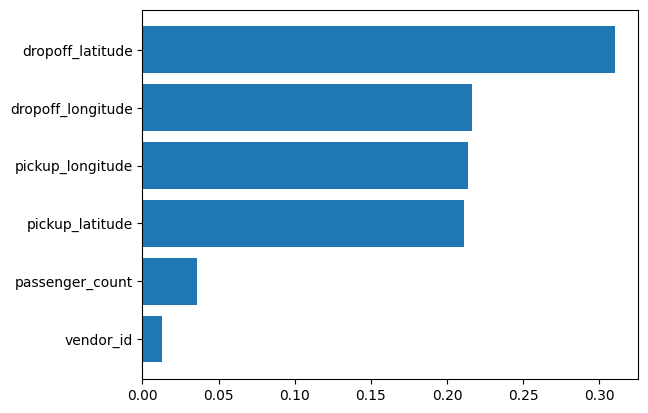

In [13]:
%matplotlib inline

from matplotlib import pyplot as plt

sorted_idx = model.feature_importances_.argsort()

plt.barh(model.feature_names_in_[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()


## Part 3 : Evaluation

In [14]:
import pandas as pd
from sklearn.model_selection import cross_validate, TimeSeriesSplit

N_SPLITS = 5

model = RandomForestRegressor(random_state=RANDOM_STATE)
splitter = TimeSeriesSplit(n_splits=N_SPLITS)

cv_losses = cross_validate(
    model,
    features,
    target,
    scoring='neg_mean_squared_log_error',
    cv=splitter,
)


In [15]:
pd.DataFrame(cv_losses).agg(['mean', 'std'])


fit_time  score_time  test_score
mean  3.838306    0.075339   -0.533614
std   2.277140    0.016488    0.060495

In [17]:
import spice

<img src="assets/nibble.png" width="300px"/>
